In [93]:
import tensorflow as tf
import keras as ks
from keras import models
from keras import metrics
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection

In [94]:
rawdata=pd.read_csv('/content/AMZN.csv').round(3)

In [95]:
rawdata=rawdata.dropna()
rawdata

,Date,High,Low,Close,Adj Close,Volume,Open,Interest,Currency,Inflation,Day,Month
0,1997-05-16,0.099,0.085,0.086,0.086,294000000.0,0.098,6.71,0.6122833,2.2,16,5
1,1997-05-19,0.089,0.081,0.085,0.085,122136000.0,0.088,6.71,0.6122833,2.2,19,5
2,1997-05-20,0.088,0.082,0.082,0.082,109344000.0,0.086,6.71,0.6122833,2.2,20,5
3,1997-05-21,0.082,0.069,0.071,0.071,377064000.0,0.082,6.71,0.6122833,2.2,21,5
4,1997-05-22,0.072,0.066,0.070,0.070,235536000.0,0.072,6.71,0.6122833,2.2,22,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6506,2023-03-24,98.300,96.400,98.130,98.130,56095400.0,98.070,3.66,0.8240278,5,24,3
6507,2023-03-27,99.340,97.080,98.040,98.040,46721300.0,99.070,3.66,0.8240278,5,27,3
6508,2023-03-28,98.440,96.290,97.240,97.240,38720100.0,98.110,3.66,0.8240278,5,28,3
6509,2023-03-29,100.420,98.560,100.250,100.250,49783300.0,98.690,3.66,0.8240278,5,29,3


In [96]:
data=pd.DataFrame()
data['Open']=rawdata['Open'].astype(np.float64)
data['High']=rawdata['High'].astype(np.float64)
data['Low']=rawdata['Low'].astype(np.float64)
data['Close']=rawdata['Close'].astype(np.float64)
data['Currency']=rawdata['Currency'].astype(np.float64)
data['Interest']=rawdata['Interest'].astype(np.float64)
data['Inflation']=rawdata['Inflation'].astype(np.float64)
data['Day']=rawdata['Day'].astype(np.int64)
data['Month']=rawdata['Month'].astype(np.int64)
data.head()

,Open,High,Low,Close,Currency,Interest,Inflation,Day,Month
0,0.098,0.099,0.085,0.086,0.612283,6.71,2.2,16,5
1,0.088,0.089,0.081,0.085,0.612283,6.71,2.2,19,5
2,0.086,0.088,0.082,0.082,0.612283,6.71,2.2,20,5
3,0.082,0.082,0.069,0.071,0.612283,6.71,2.2,21,5
4,0.072,0.072,0.066,0.070,0.612283,6.71,2.2,22,5


In [97]:
train=data.iloc[:int(0.8*len(data))]
test=data.iloc[int(0.8*len(data)):]

In [98]:
def sliding_window(stockdata):
  window_size=7
  windowed_data=[]
  for i in range(len(stockdata)-window_size):
      window=stockdata[i:i+window_size]
      windowed_data.append(window)
  return np.array(windowed_data)

In [99]:
#run to keep batches ordered
X=sliding_window(train)
Y=train['Close'][7:]
TestingX=sliding_window(test)
TestingY=test['Close'][7:]

In [100]:
x_train,x_test,y_train,y_test=model_selection.train_test_split(X,Y,test_size=0.2)

In [101]:
metric=[metrics.RootMeanSquaredError(),metrics.MeanAbsoluteError(),metrics.MeanAbsolutePercentageError(),metrics.MeanSquaredLogarithmicError()]
def modelbuild():
    model = models.Sequential()
    model.add(ks.layers.LSTM(256, return_sequences=True,activation='relu', input_shape=(7,9),dropout=0.1,recurrent_dropout=0.1))
    model.add(ks.layers.SimpleRNN(32,activation='relu'))
    model.add(ks.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=metric)
    return model

In [102]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 7, 256)            272384    
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 32)                9248      
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
Total params: 281,665
Trainable params: 281,665
Non-trainable params: 0
_________________________________________________________________


In [103]:
model=modelbuild()
stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),callbacks=[stop])
#history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test))

test_loss, rmse, mae, mape, msle = model.evaluate(x_test, y_test, verbose=2)

print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)

Epoch 1/10
130/130 [==============================] - 15s 76ms/step - loss: 6.0840 - root_mean_squared_error: 2.4666 - mean_absolute_error: 1.1035 - mean_absolute_percentage_error: 31.8238 - mean_squared_logarithmic_error: 0.0554 - val_loss: 0.6292 - val_root_mean_squared_error: 0.7932 - val_mean_absolute_error: 0.4372 - val_mean_absolute_percentage_error: 7.8531 - val_mean_squared_logarithmic_error: 0.0037
Epoch 2/10
130/130 [==============================] - 12s 91ms/step - loss: 0.8215 - root_mean_squared_error: 0.9064 - mean_absolute_error: 0.5217 - mean_absolute_percentage_error: 13.2880 - mean_squared_logarithmic_error: 0.0075 - val_loss: 1.3229 - val_root_mean_squared_error: 1.1502 - val_mean_absolute_error: 0.6369 - val_mean_absolute_percentage_error: 12.1804 - val_mean_squared_logarithmic_error: 0.0075
Epoch 3/10
130/130 [==============================] - 12s 92ms/step - loss: 0.6059 - root_mean_squared_error: 0.7784 - mean_absolute_error: 0.4586 - mean_absolute_percentage_err

In [104]:
test_loss, rmse, mae, mape, msle = model.evaluate(TestingX,TestingY,verbose=1)
print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)
print("Want to save model?")
c=input()
if c=='y':
  ks.Model.save(model,'/content/models')

41/41 [==============================] - 1s 15ms/step - loss: 62.2538 - root_mean_squared_error: 7.8901 - mean_absolute_error: 6.5658 - mean_absolute_percentage_error: 5.4627 - mean_squared_logarithmic_error: 0.0042

Mean Squared Error:  62.2537727355957
Root Mean Squared Error:  7.890106201171875
Mean Absolute Error:  6.565781593322754
Mean Absolute Percentage Error:  5.462669849395752
Mean Squared Logarithmic Error:  0.00423821434378624
Want to save model?
y


204/204 [==============================] - 6s 26ms/step


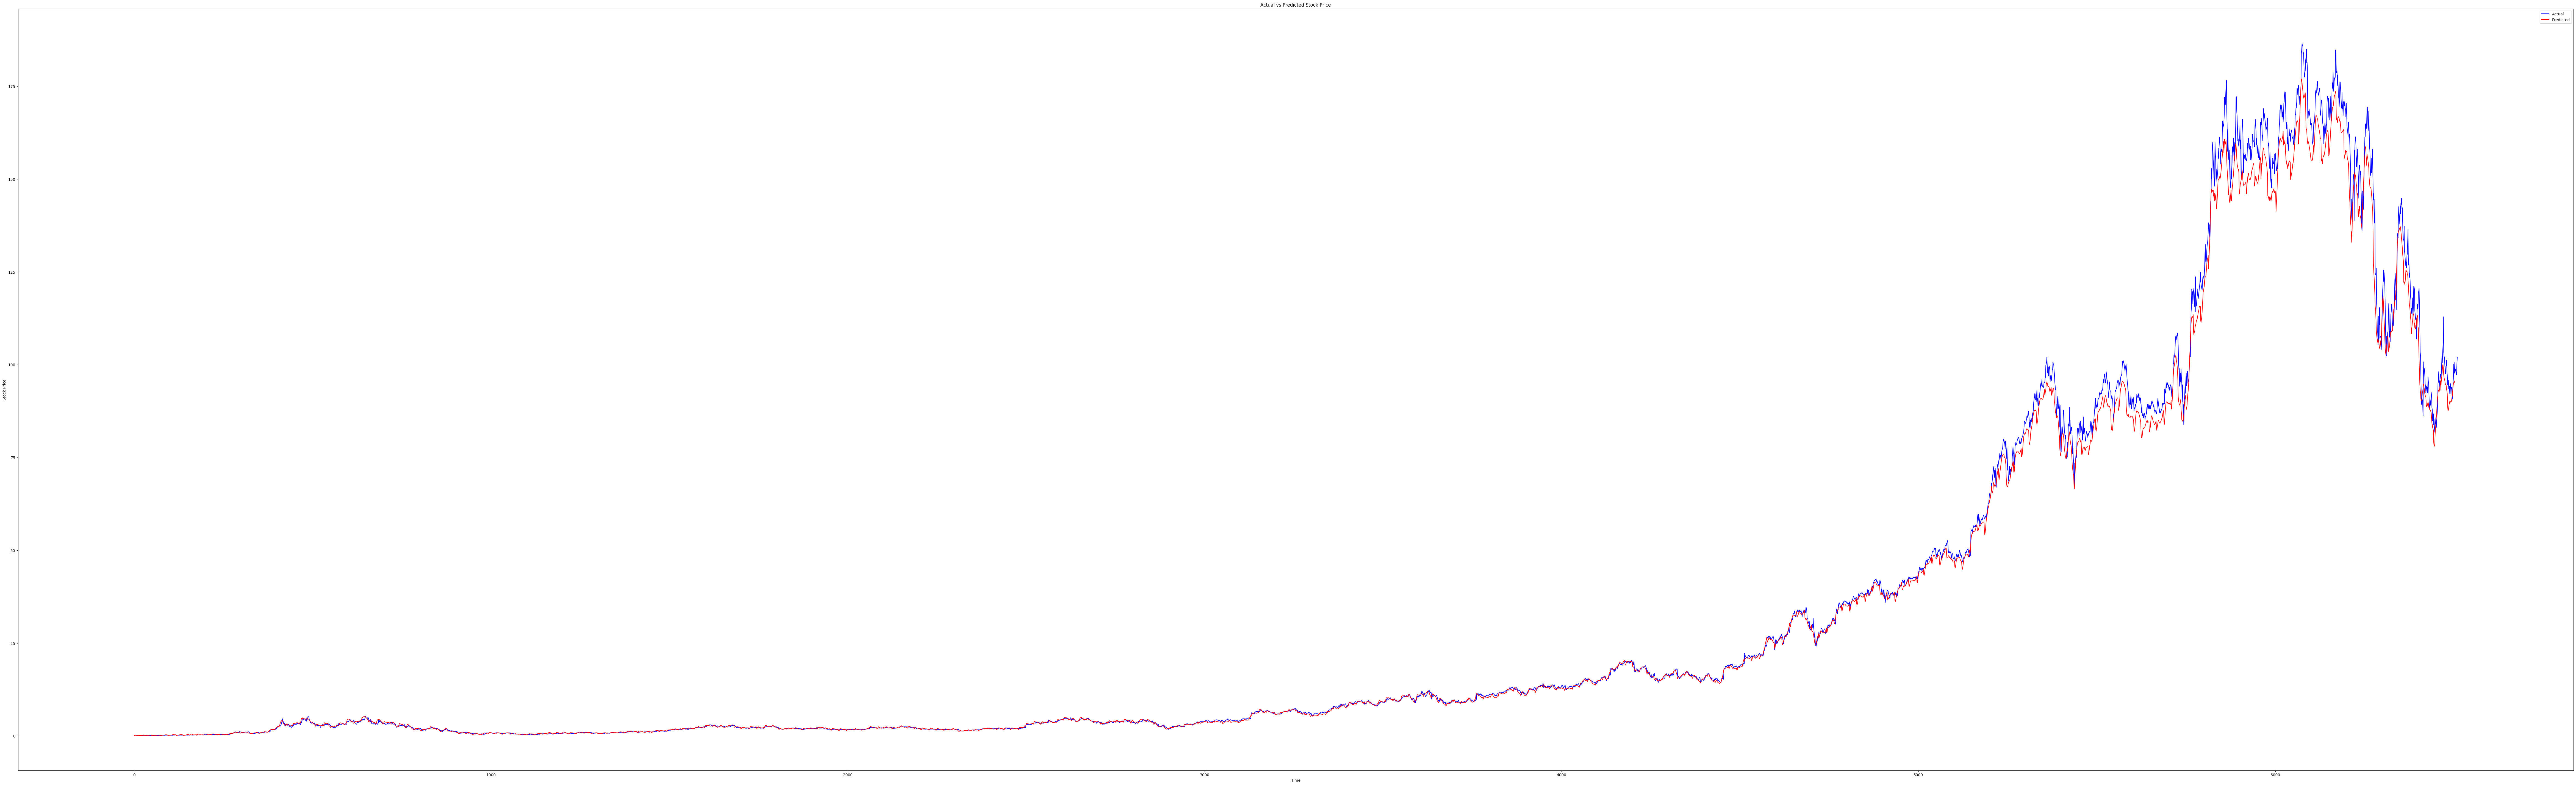

In [105]:
predicted_prices=model.predict(sliding_window(data))
actual_prices=data['Close'][7:]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(120,36))
plt.plot(actual_prices, color='blue', label='Actual')
plt.plot(predicted_prices, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.show()